In [39]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA

import yaml
import os
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,make_scorer
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler


#from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.model_selection import  cross_validate,  RepeatedStratifiedKFold,cross_val_score,GridSearchCV, train_test_split,cross_val_score
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score,make_scorer

### Data ingestion 

In [40]:
warnings.filterwarnings("ignore")

In [41]:
# Obtener la ruta del directorio donde está el notebook
current_dir = Path().resolve()  # Esto obtiene el directorio actual

# Crear la ruta al archivo params.yaml, ajustando a la estructura correcta
params_path = current_dir.parent / 'params.yaml'  # Esto asume que params.yaml está en el directorio padre

# Cargar la configuración desde params.yaml
try:
    with open(params_path, 'r') as file:
        config = yaml.safe_load(file)

    # Imprimir el contenido de config para verificar
    print(config)
except FileNotFoundError:
    print(f"No se pudo encontrar el archivo: {params_path}")

{'base': {'random_stage': 10}, 'data': {'dataset_id': 891, 'save_processed_data': True, 'processed_data_path': 'data/processed/cdc_diabetes_health_indicators.csv'}, 'train': None, 'train_size': 0.8, 'reports': None}


In [42]:
class function_fase_1:
    def __init__(self):
        pass
    class load_data:
        def __init__(self,filepath):
            self.data, self.filepath=self.load_data(filepath)
        def load_data(self,filepath):
        # data (as pandas dataframes)
            X = filepath.data.features
            y = filepath.data.targets
            # Merge them into a single DataFrame
            data = X.copy()
            data['Diabetes_binary'] = y
            return data,filepath
    
    class explore_data:
        def __init__(self,data,filepath):
            self.data=data
            self.filepath=filepath
            self.explore_data(data,filepath)
    
        def explore_data(self,data, filepath):
            print(filepath.metadata)  ## considerar
            print(filepath.variables) ## considerar
            print(data.head())
            print(data.describe().T) ## considerar
            print(data.info()) ## considerar
            print(data.shape)
            print(data.isnull().sum())
            
            # Automatically find binary columns
            binary_columns = [col for col in data.columns if set(data[col].unique()).issubset({0, 1})]
            
            # Convert found binary columns to bool
            for col in binary_columns:
              data[col] = data[col].astype('bool')
            
            # List of categorical columns to convert
            categorical_columns = ['GenHlth', 'Age', 'Education', 'Income']
            
            # Convert specified columns to category
            for col in categorical_columns:
              data[col] = data[col].astype('category')
            
            # Check the data types
            print(data.dtypes)
        
    class plot_graph:
    # 1. Summary Statistics
        def __init__(self,data):
            self.data=data
            self.summary_statistics(data)
            self.plot_numeric_distributions(data)
            self.plot_binary_counts(data,'Diabetes_binary')
            self.plot_boxplots(data,'Diabetes_binary')
            self.plot_crosstab(data,'Diabetes_binary')
            self.plot_correlation_heatmap(data)
        
        def summary_statistics(self,data):
            print("Summary Statistics:")
            print(data.describe(include='all'))
        
        # 2. Distribution of Numeric Variables
        def plot_numeric_distributions(self,data):
            numeric_columns = data.select_dtypes(include=['int64']).columns
            for col in numeric_columns:
              plt.figure(figsize=(10, 5))
              sns.histplot(data[col], bins=30, kde=True)
              plt.title(f'Distribution of {col}')
              plt.xlabel(col)
              plt.ylabel('Frequency')
              plt.grid()
              plt.show()
        
        # 3. Count Plots for Binary Variables against the Target
        def plot_binary_counts(self,data, target):
            binary_columns = data.select_dtypes(include=['bool']).columns
            for col in binary_columns:
              plt.figure(figsize=(10, 5))
              sns.countplot(x=data[col], hue=data[target])
              plt.title(f'Count of {col} by {target}')
              plt.xlabel(col)
              plt.ylabel('Count')
              plt.legend(title=target)
              plt.grid()
              plt.show()
            
        # 4. Box Plots for Continuous Variables by Target Variable
        def plot_boxplots(self,data, target):
            numeric_columns = data.select_dtypes(include=['int64']).columns
            for num_col in numeric_columns:
              plt.figure(figsize=(10, 5))
              sns.boxplot(x=data[target], y=data[num_col])
              plt.title(f'Boxplot of {num_col} by {target}')
              plt.xlabel(target)
              plt.ylabel(num_col)
              plt.grid()
              plt.show()
        
        # 5. Crosstabulation for Categorical Variables against the Target
        def plot_crosstab(self,data, target):
            categorical_columns = data.select_dtypes(include=['category']).columns
            for cat_col in categorical_columns:
              crosstab = pd.crosstab(data[cat_col], data[target])
              print(f'Crosstab for {cat_col} vs {target}:')
              print(crosstab)
              sns.heatmap(crosstab, annot=True, fmt="d", cmap='Blues')
              plt.title(f'Crosstab Heatmap of {cat_col} by {target}')
              plt.ylabel(cat_col)
              plt.xlabel(target)
              plt.show()
        
        # 6. Correlation Heatmap for Numeric Variables
        def plot_correlation_heatmap(self,data):
            numeric_data = data.select_dtypes(include=['int64'])
            correlation_matrix = numeric_data.corr()
            plt.figure(figsize=(15, 15))
            sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
            plt.title('Correlation Heatmap')
            plt.show()
    
    class transformation_type:
        def __init__(self,data):
            self.data=data
            self.transformation_type(data)
        
        def transformation_type(self,data):
        # Create a temporal DataFrame  for the transformations
            temp_data = data.copy()
            
            # Create the transformations in the temporary DataFrame
            temp_data['Log_BMI'] = np.log(temp_data['BMI'] + 1)
            temp_data['Log_MentHlth'] = np.log(temp_data['MentHlth'] + 1)
            temp_data['Log_PhysHlth'] = np.log(temp_data['PhysHlth'] + 1)
            
            temp_data['Sqrt_BMI'] = np.sqrt(temp_data['BMI'] + 1)
            temp_data['Sqrt_MentHlth'] = np.sqrt(temp_data['MentHlth'] + 1)
            temp_data['Sqrt_PhysHlth'] = np.sqrt(temp_data['PhysHlth'] + 1)
            
            # Yeo-Johnson Transformation
            pt = PowerTransformer(method='yeo-johnson')
            temp_data[['YeoJohnson_BMI', 'YeoJohnson_MentHlth', 'YeoJohnson_PhysHlth']] = pt.fit_transform(temp_data[['BMI', 'MentHlth', 'PhysHlth']])
            
            # Configure the figure for multiple subgraphs
            fig, axes = plt.subplots(5, 3, figsize=(15, 20))
            fig.suptitle('Comparison of Distributions of Numerical Variables and Transforms', fontsize=16)
            
            # Originals
            for i, col in enumerate(['BMI', 'MentHlth', 'PhysHlth']):
              sns.histplot(data[col], bins=30, kde=True, ax=axes[0, i])
              axes[0, i].set_title(f'Distribución de {col}')
              axes[0, i].set_xlabel(col)
              axes[0, i].set_ylabel('Frecuencia')
            
            # Logarithmic Transformation
            for i, col in enumerate(['Log_BMI', 'Log_MentHlth', 'Log_PhysHlth']):
              sns.histplot(temp_data[col], bins=30, kde=True, ax=axes[1, i])
              axes[1, i].set_title(f'Distribución Log de {col}')
              axes[1, i].set_xlabel(col)
              axes[1, i].set_ylabel('Frecuencia')
            
            # Square Root Transformation
            for i, col in enumerate(['Sqrt_BMI', 'Sqrt_MentHlth', 'Sqrt_PhysHlth']):
              sns.histplot(temp_data[col], bins=30, kde=True, ax=axes[2, i])
              axes[2, i].set_title(f'Distribución Raíz Cuadrada de {col}')
              axes[2, i].set_xlabel(col)
              axes[2, i].set_ylabel('Frecuencia')
            
            # Yeo-Johnson Transformation
            for i, col in enumerate(['YeoJohnson_BMI', 'YeoJohnson_MentHlth', 'YeoJohnson_PhysHlth']):
              sns.histplot(temp_data[col], bins=30, kde=True, ax=axes[3, i])
              axes[3, i].set_title(f'Distribución Yeo-Johnson de {col}')
              axes[3, i].set_xlabel(col)
              axes[3, i].set_ylabel('Frecuencia')
            
            # Occupying the space in the last row (you can adjust or add more graphs)
            for ax in axes[4]:
              ax.axis('off')  #Or you can add other graphs here
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  #  Adjust design
            plt.show()
        
    class transformation:
        def __init__(self,data):
            self.data=data
            self.codification(data)
            self.transform(data)
        # 1. Codification
        def codification(self,data):
        # Inicializa el codificador
            label_encoder = LabelEncoder()
            
            # Aplica el Label Encoding a las columnas ordinales
            data['GenHlth'] = label_encoder.fit_transform(data['GenHlth'])
            data['Age'] = label_encoder.fit_transform(data['Age'])
            data['Education'] = label_encoder.fit_transform(data['Education'])
            data['Income'] = label_encoder.fit_transform(data['Income'])
            
            # Muestra el DataFrame transformado
            print(data[['GenHlth', 'Age', 'Education','Income']])
            return data
        
        # 2. Transformation
        def transform(self,data):
        # Aplicar Yeo-Johnson y reemplazar las columnas originales
            pt = PowerTransformer(method='yeo-johnson')
            data[['BMI', 'MentHlth', 'PhysHlth']] = pt.fit_transform(data[['BMI', 'MentHlth', 'PhysHlth']])
            
            # Estandarizar las variables transformadas y reemplazar las columnas originales
            scaler = StandardScaler()
            data[['BMI', 'MentHlth', 'PhysHlth']] = scaler.fit_transform(data[['BMI', 'MentHlth', 'PhysHlth']])
            
            # Mostrar el DataFrame transformado y estandarizado
            print(data[['BMI', 'MentHlth', 'PhysHlth']])
            return data
    
    class process_apply_PCA:
        def __init__(self,data):
            self.data=data
            self.final_df=self.apply_PCA(data)
            
        def apply_PCA(self,data):

        # Seleccionar características para PCA (variables ya transformadas y escaladas)
            X = data[['BMI', 'MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']]
            
            # Inicializa PCA y ajusta el modelo
            pca = PCA()
            pca.fit(X)
            
            # Variancia explicada por cada componente
            explained_variance = pca.explained_variance_ratio_
            
            # Crea un gráfico de codo
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
            plt.title('Varianza Explicada por Componentes Principales')
            plt.xlabel('Número de Componentes Principales')
            plt.ylabel('Proporción de Varianza Explicada')
            plt.grid()
            plt.show()
            
            # Crea un gráfico de varianza acumulada
            plt.figure(figsize=(10, 6))
            cumulative_variance = explained_variance.cumsum()
            plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
            plt.title('Varianza Acumulada por Componentes Principales')
            plt.xlabel('Número de Componentes Principales')
            plt.ylabel('Varianza Acumulada')
            plt.grid()
            plt.axhline(y=0.92, color='r', linestyle='--')  # Umbral del 92%
            plt.show()
            
            # Seleccionar características para PCA (variables ya transformadas y escaladas)
            X = data[['BMI', 'MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']]
            
            # Aplicar PCA
            pca = PCA(n_components=5)  # Elegir cuántas componentes principales mantener
            X_pca = pca.fit_transform(X)
            
            # Convertir el resultado a un DataFrame
            pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(5)])
            
            # Unir las componentes principales con el DataFrame original, excluyendo las variables originales
            final_df = pd.concat([data.drop(columns=['BMI', 'MentHlth', 'PhysHlth', 'GenHlth', 'Age', 'Education', 'Income']).reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)
            
            # Mostrar el DataFrame final
            print(final_df.head())
            return final_df
            
                        
                        # Run EDA Functions

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

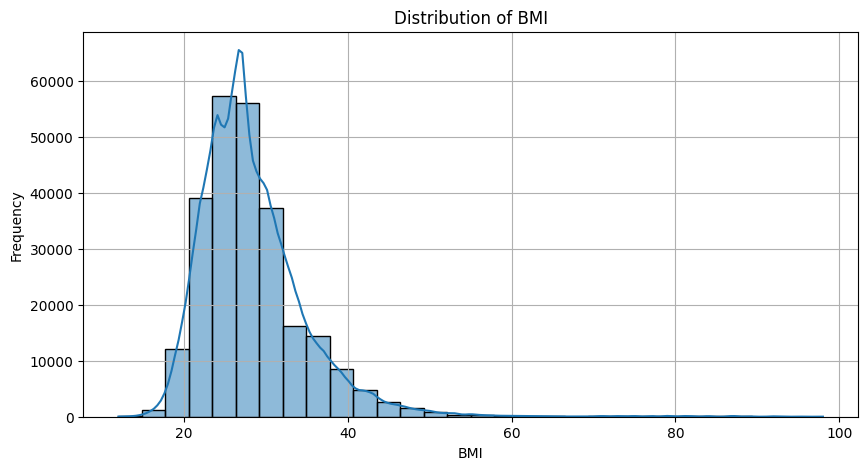

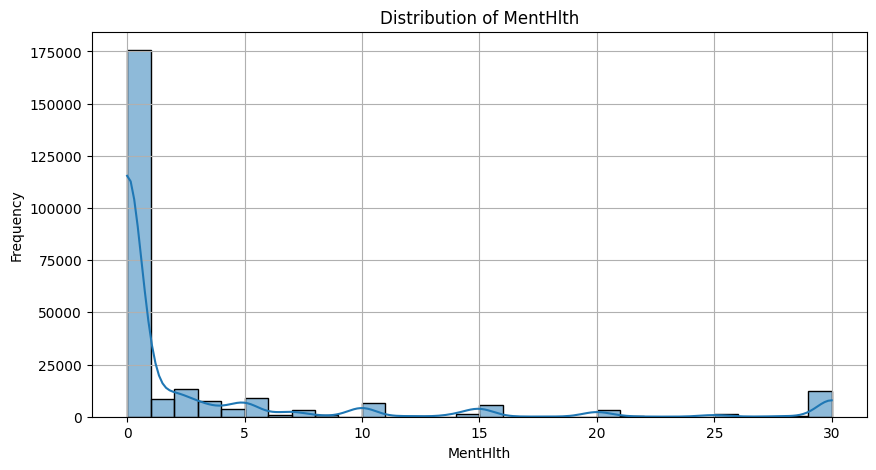

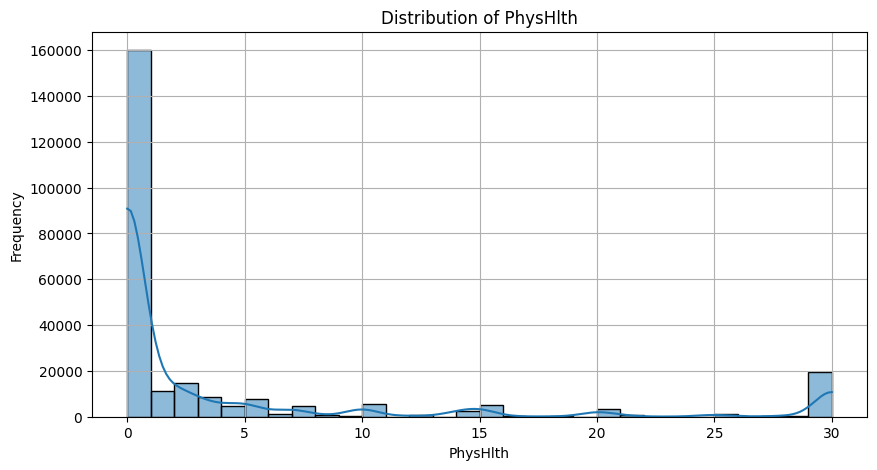

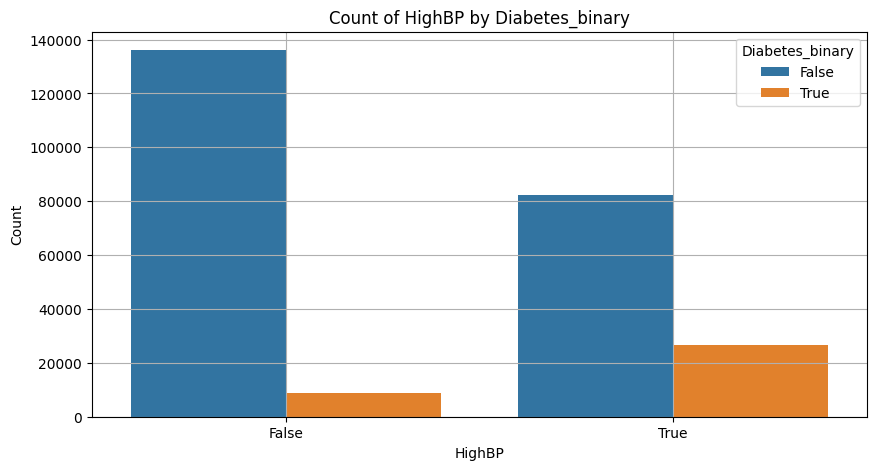

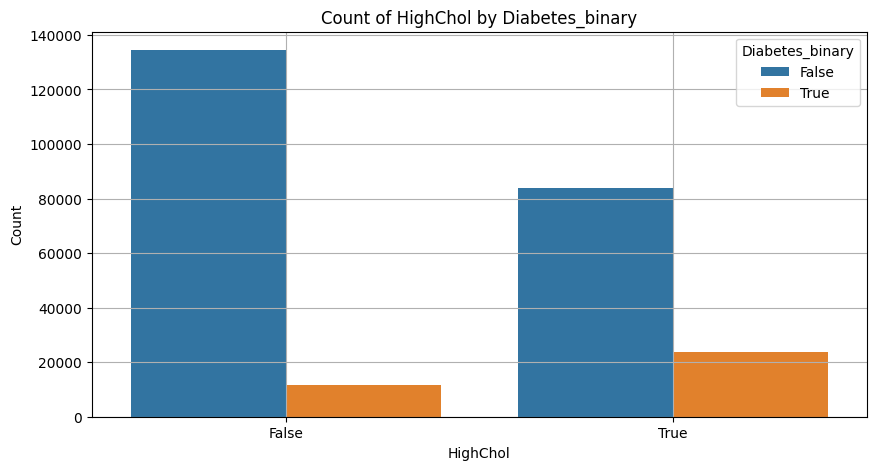

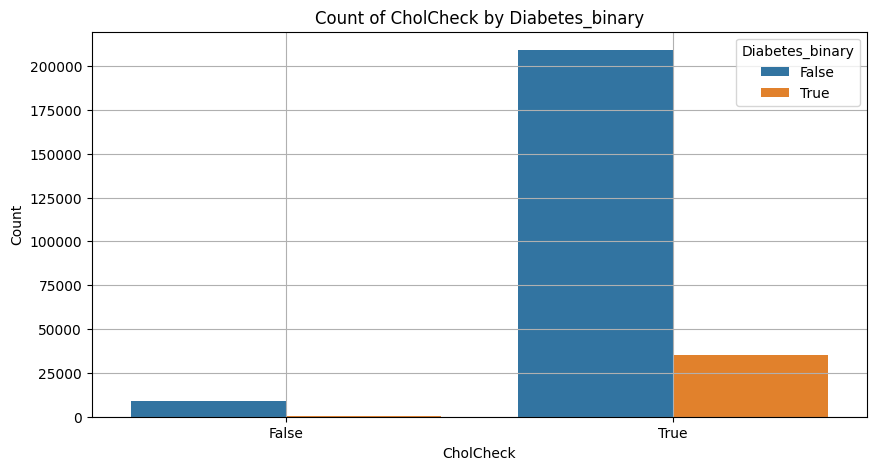

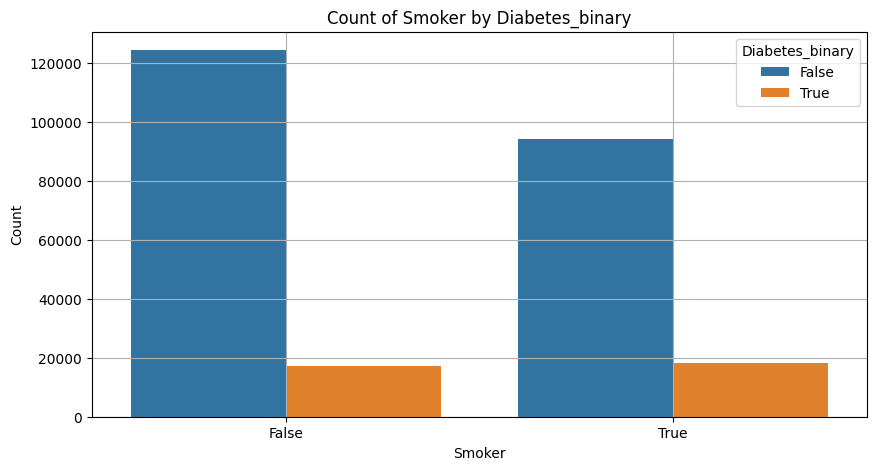

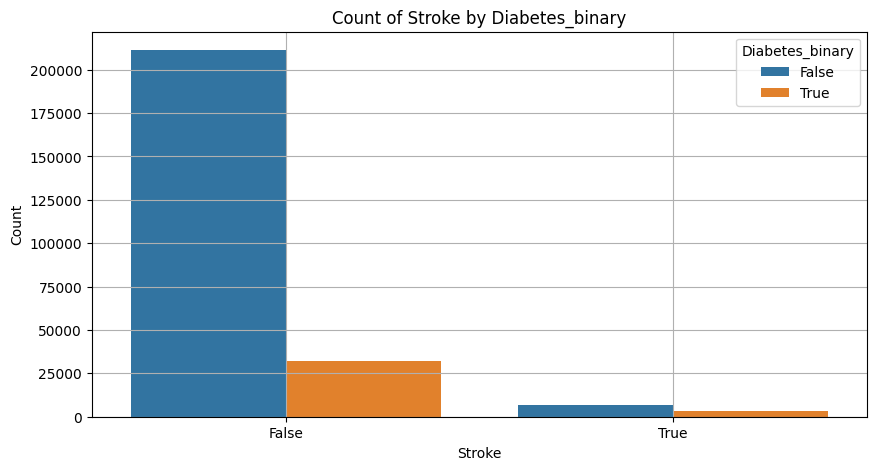

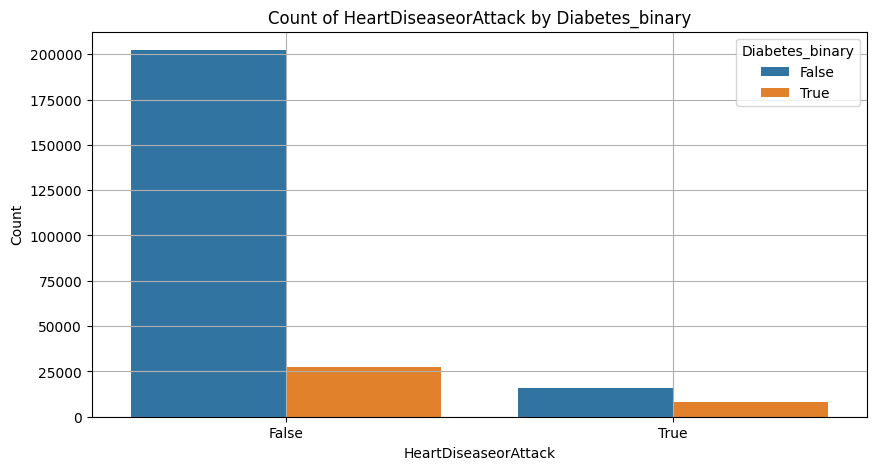

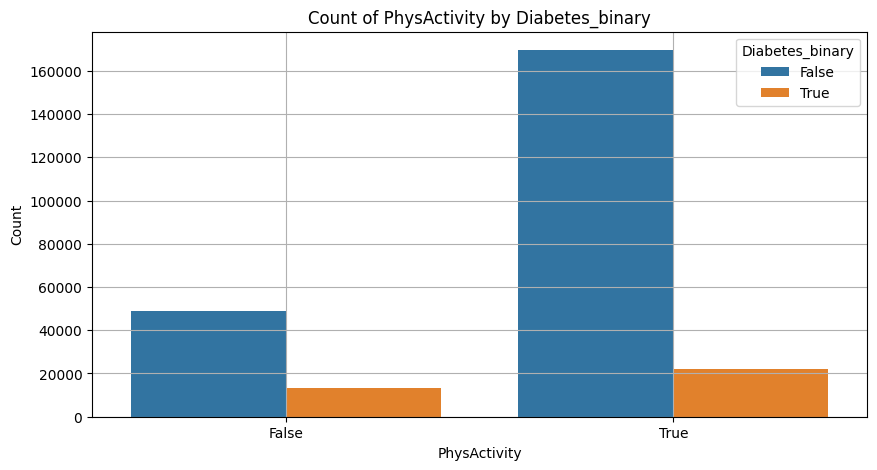

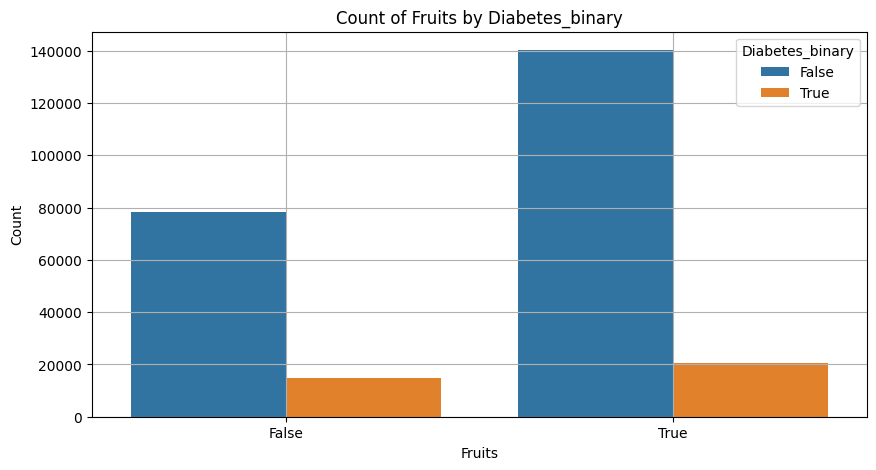

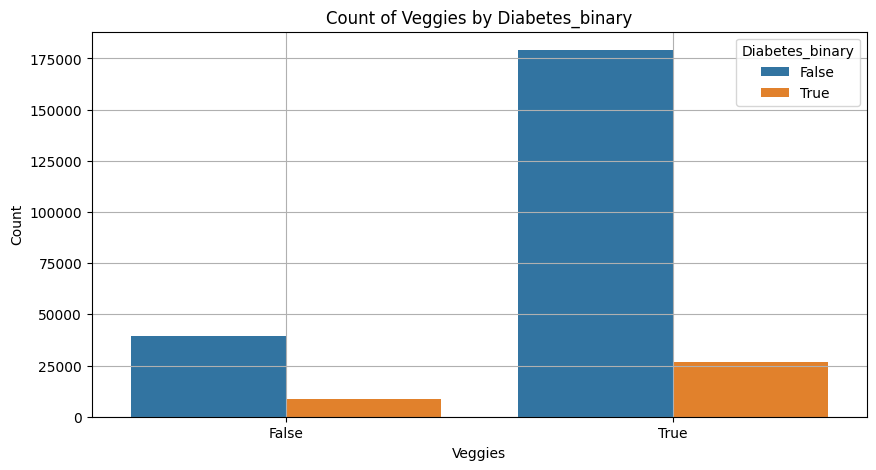

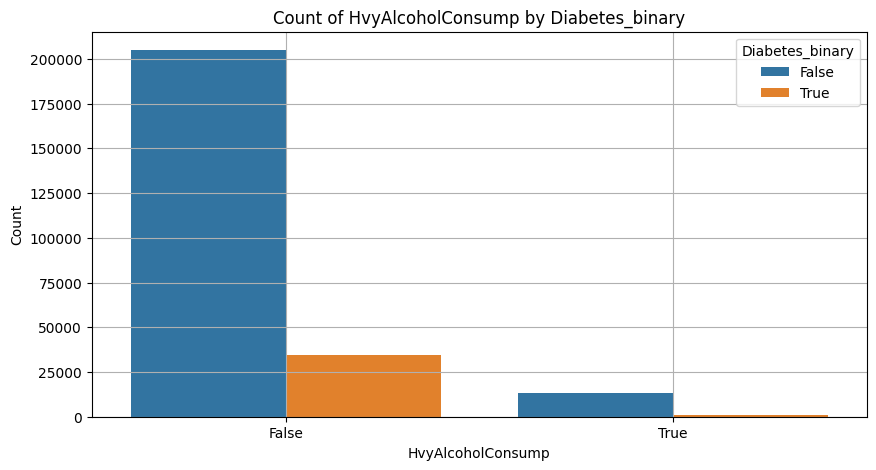

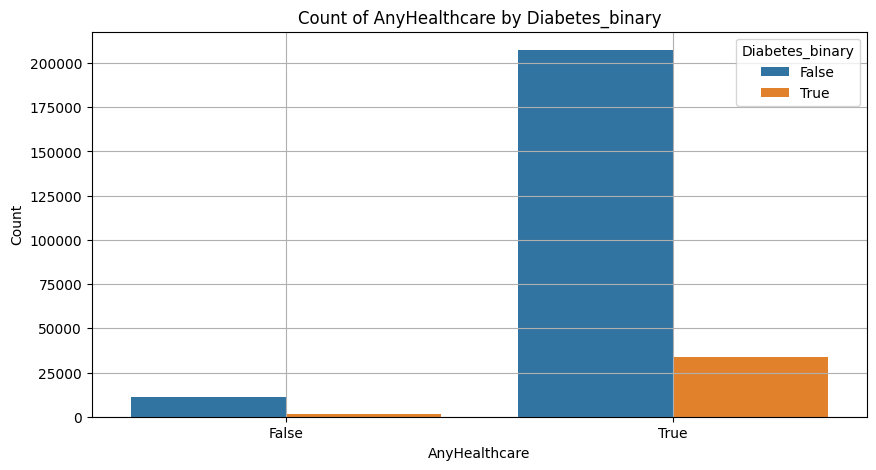

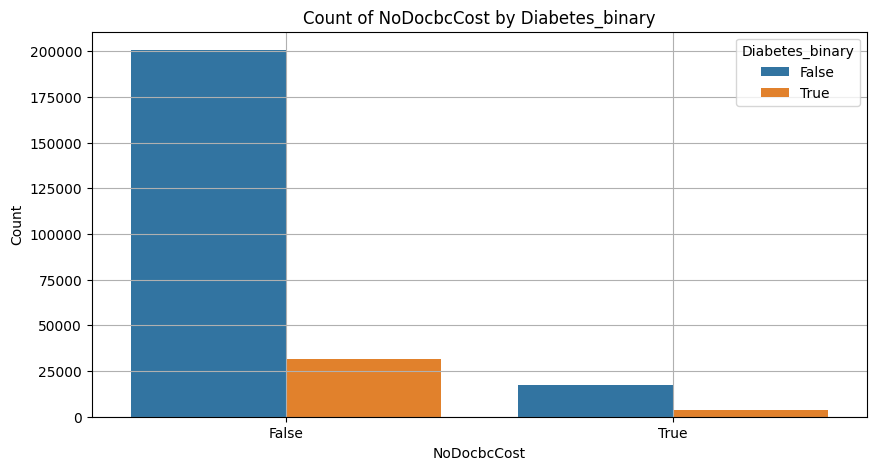

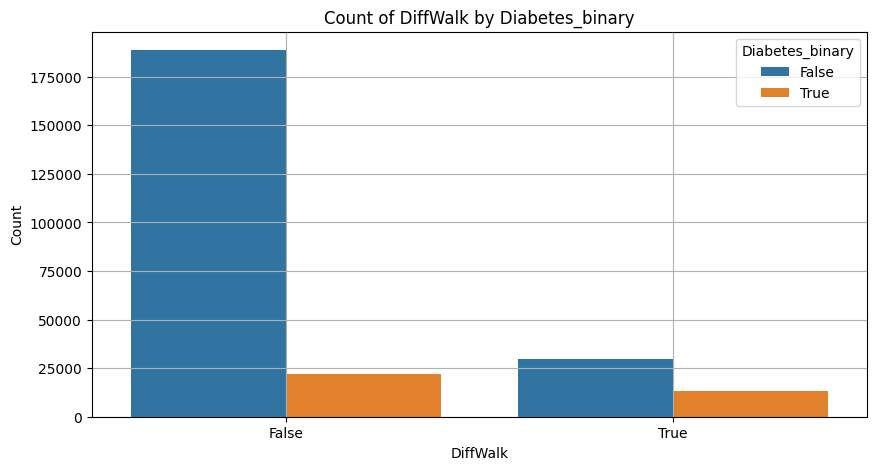

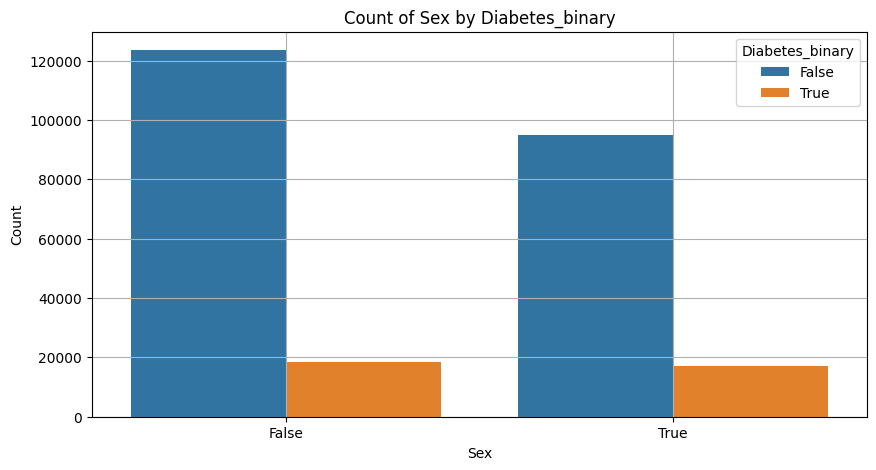

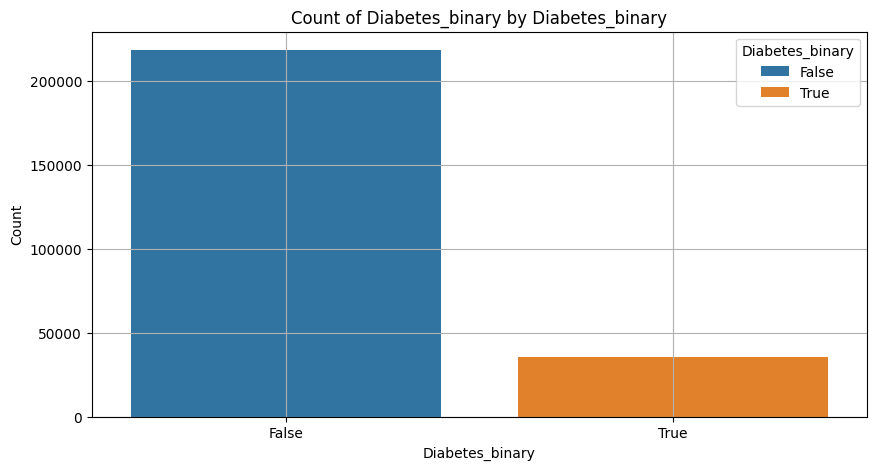

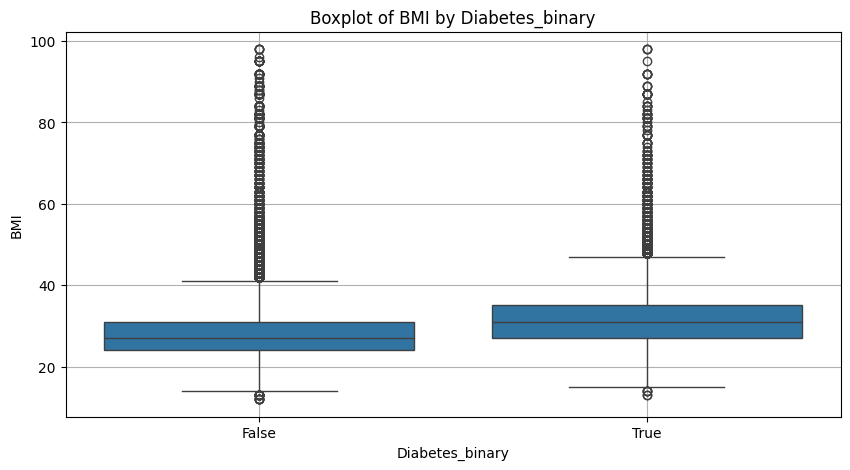

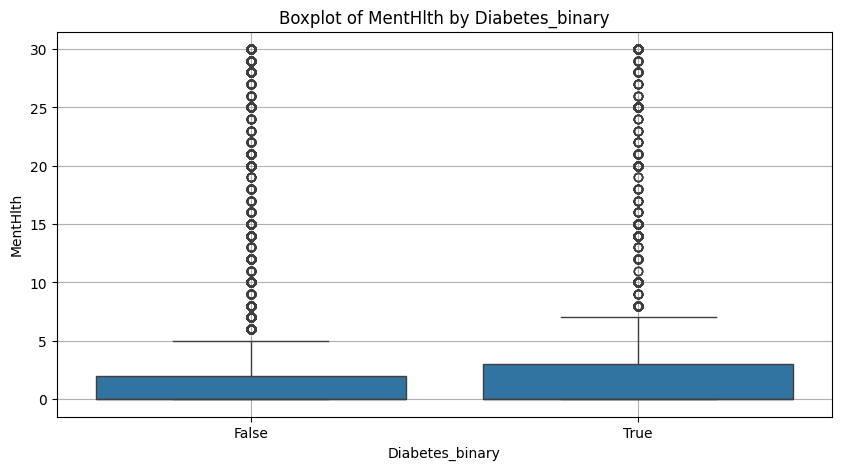

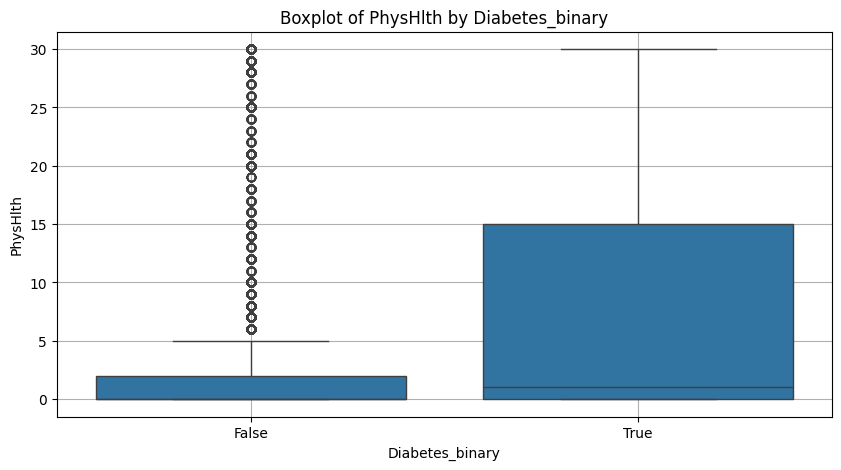

Crosstab for GenHlth vs Diabetes_binary:
Diabetes_binary  False  True 
GenHlth                      
1                44159   1140
2                82703   6381
3                62189  13457
4                21780   9790
5                 7503   4578


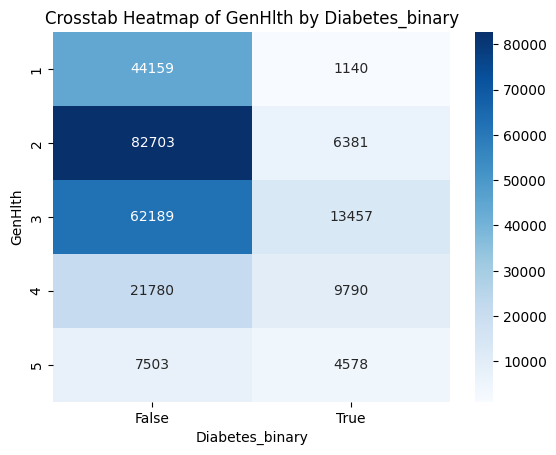

Crosstab for Age vs Diabetes_binary:
Diabetes_binary  False  True 
Age                          
1                 5622     78
2                 7458    140
3                10809    314
4                13197    626
5                15106   1051
6                18077   1742
7                23226   3088
8                26569   4263
9                27511   5733
10               25636   6558
11               18392   5141
12               12577   3403
13               14154   3209


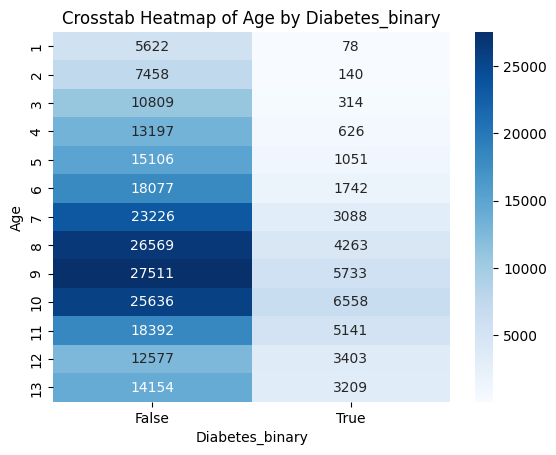

Crosstab for Education vs Diabetes_binary:
Diabetes_binary  False  True 
Education                    
1                  127     47
2                 2860   1183
3                 7182   2296
4                51684  11066
5                59556  10354
6                96925  10400


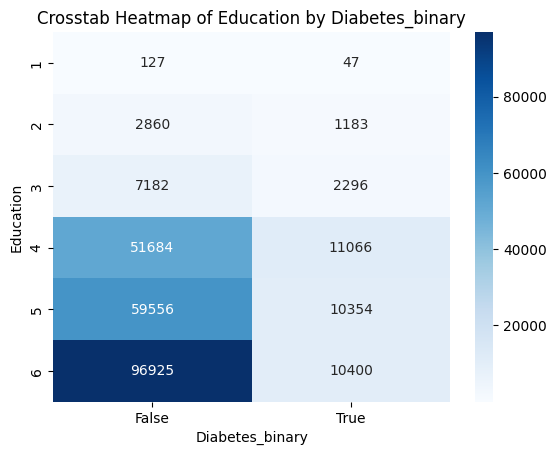

Crosstab for Income vs Diabetes_binary:
Diabetes_binary  False  True 
Income                       
1                 7428   2383
2                 8697   3086
3                12426   3568
4                16081   4054
5                21379   4504
6                31179   5291
7                37954   5265
8                83190   7195


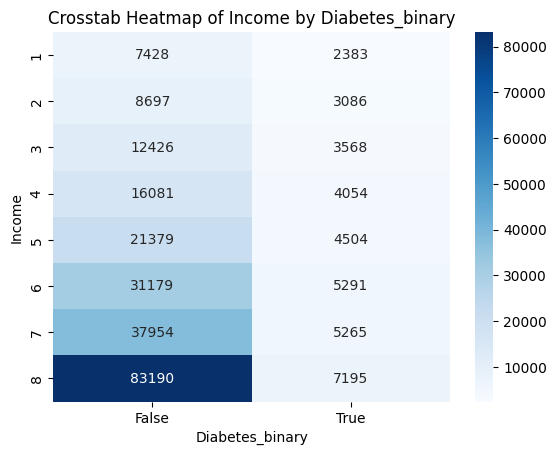

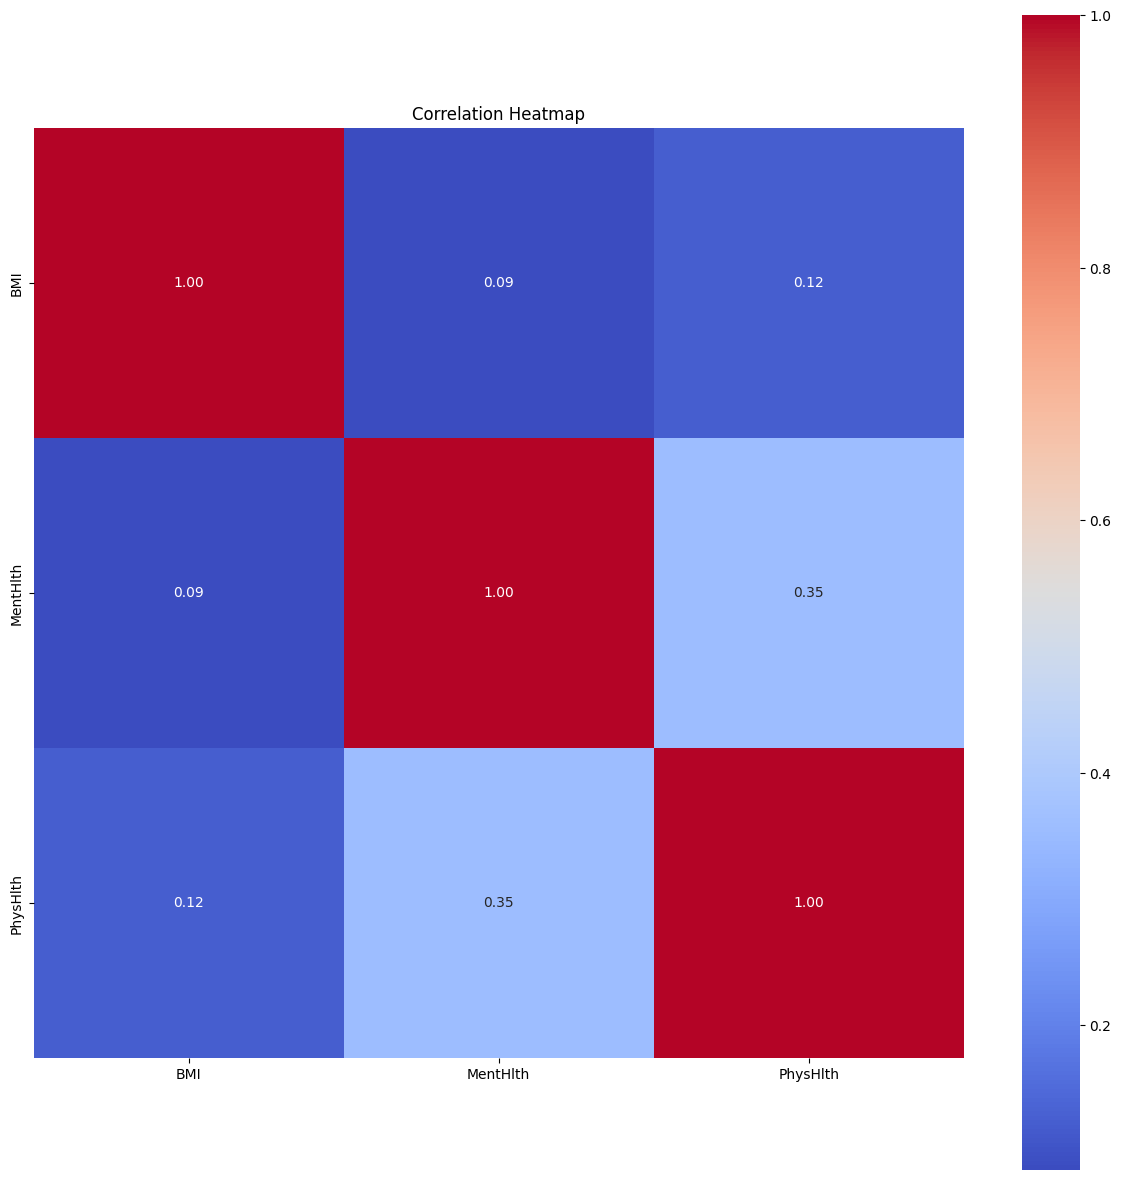

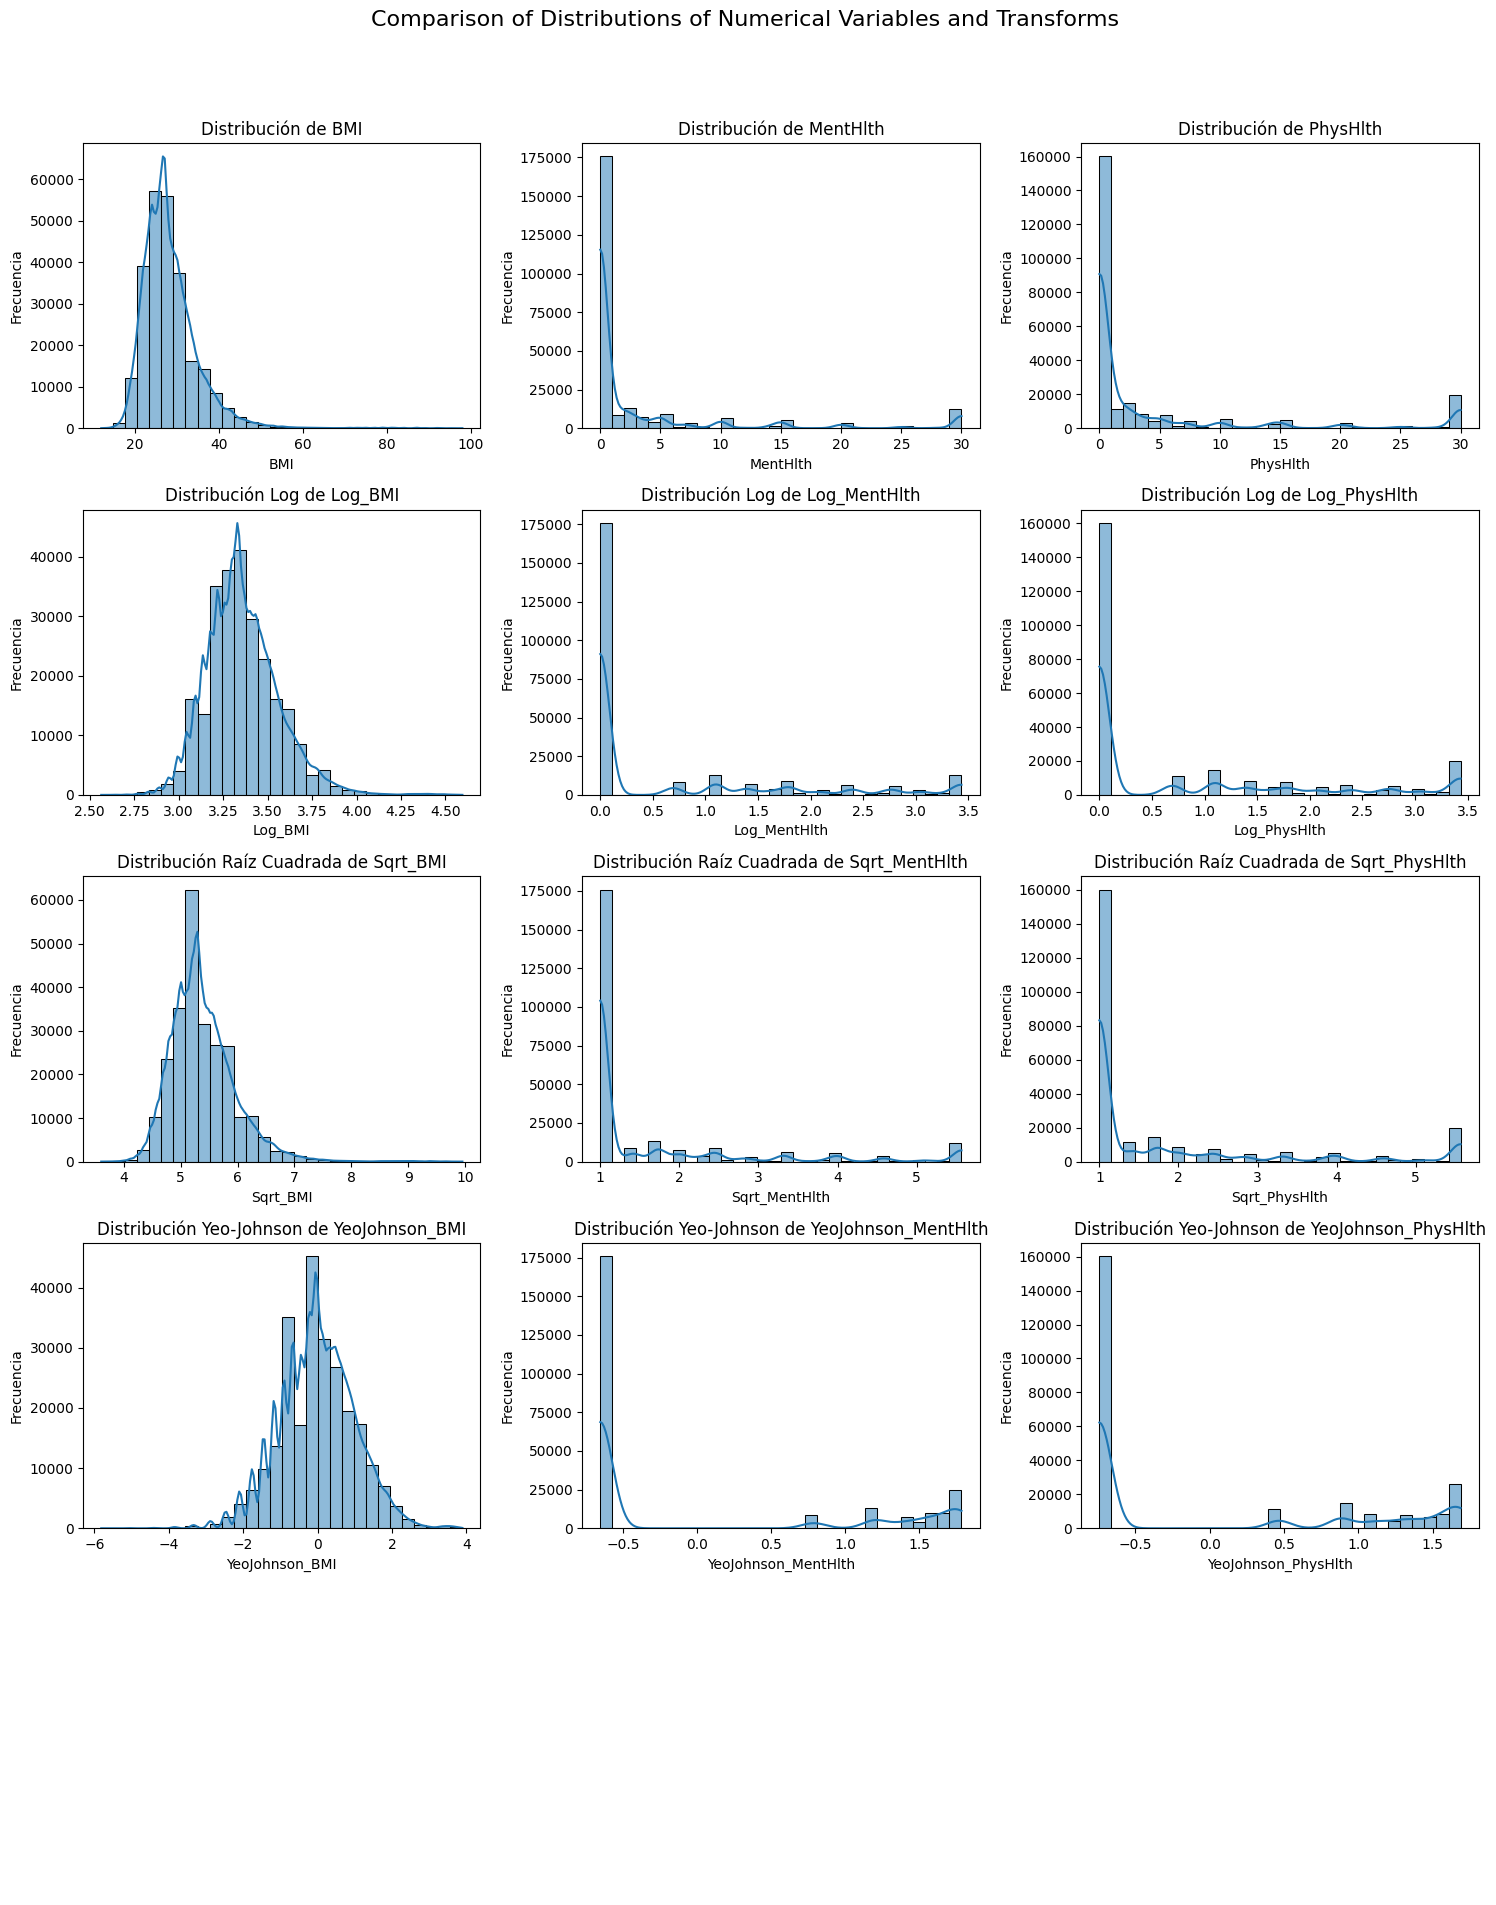

        GenHlth  Age  Education  Income
0             4    8          3       2
1             2    6          5       0
2             4    8          3       7
3             1   10          2       5
4             1   10          4       3
...         ...  ...        ...     ...
253675        2    4          5       6
253676        3   10          1       3
253677        0    1          4       1
253678        2    6          4       0
253679        1    8          5       1

[253680 rows x 4 columns]
             BMI  MentHlth  PhysHlth
0       1.638596  1.756345  1.600664
1      -0.445654 -0.656074 -0.740983
2       0.134514  1.783950  1.687864
3      -0.045740 -0.656074 -0.740983
4      -0.668354  1.387448 -0.740983
...          ...       ...       ...
253675  2.043198 -0.656074  1.316475
253676 -2.467499 -0.656074 -0.740983
253677  0.134514 -0.656074 -0.740983
253678 -0.908655 -0.656074 -0.740983
253679 -0.445654 -0.656074 -0.740983

[253680 rows x 3 columns]


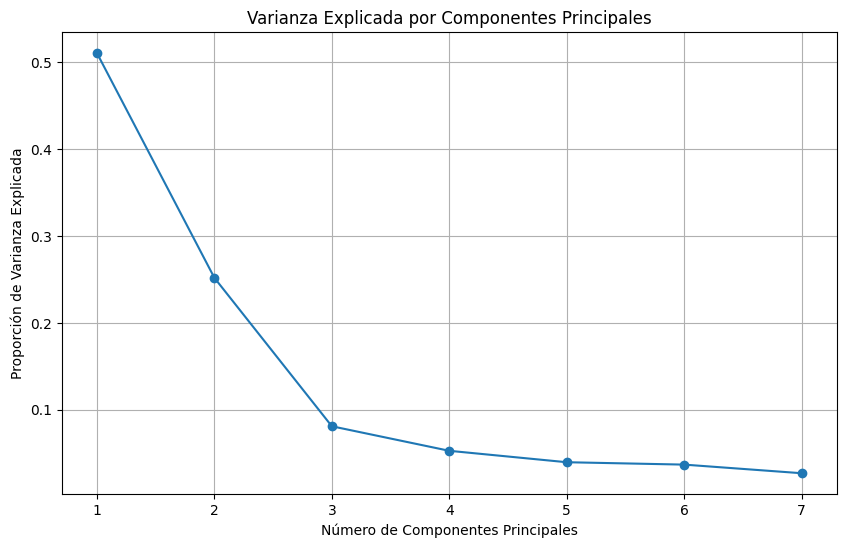

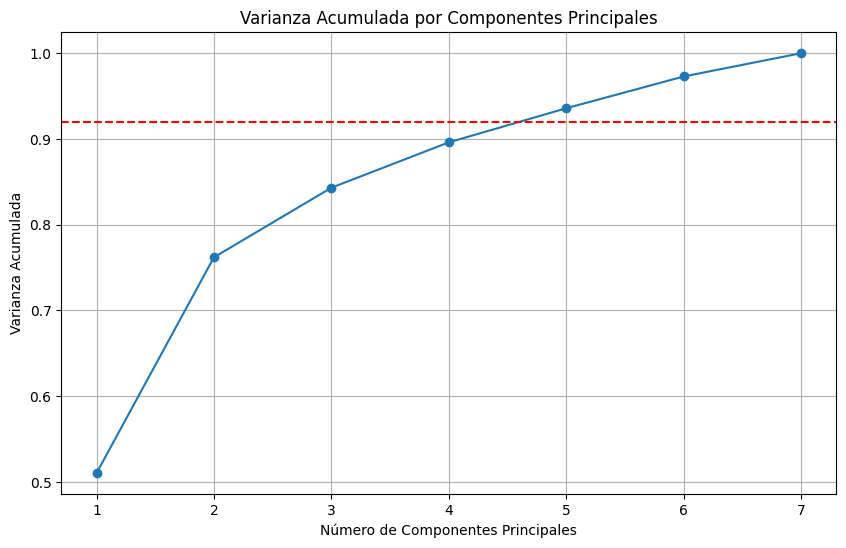

   HighBP  HighChol  CholCheck  Smoker  Stroke  HeartDiseaseorAttack  \
0    True      True       True    True   False                 False   
1   False     False      False    True   False                 False   
2    True      True       True   False   False                 False   
3    True     False       True   False   False                 False   
4    True      True       True   False   False                 False   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  \
0         False   False     True              False           True   
1          True   False    False              False          False   
2         False    True    False              False           True   
3          True    True     True              False           True   
4          True    True     True              False           True   

   NoDocbcCost  DiffWalk    Sex  Diabetes_binary       PC1       PC2  \
0        False      True  False            False  1.694009 -4.000470   
1 

In [43]:
#cdc_diabetes_health_indicators=fetch_ucirepo(id=891)
cdc_diabetes_health_indicators = fetch_ucirepo(id=config["data"]["dataset_id"])
main_function=function_fase_1()
loading_data=main_function.load_data(cdc_diabetes_health_indicators)
data,filepath=loading_data.data,loading_data.filepath
exploration=main_function.explore_data(data,filepath)
visualization=main_function.plot_graph(data)
transformation_type=main_function.transformation_type(data)
transformation=main_function.transformation(data)
application_PCA=main_function.process_apply_PCA(data)
final_df=application_PCA.final_df

In [44]:
final_df

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Diabetes_binary,PC1,PC2,PC3,PC4,PC5
0,True,True,True,True,False,False,False,False,True,False,True,False,True,False,False,1.694009,-4.000470,2.533113,0.462890,0.393024
1,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,-0.149524,-4.389937,-2.200268,-0.352470,1.038007
2,True,True,True,False,False,False,False,True,False,False,True,True,True,False,False,0.834423,0.581106,3.737161,-0.511597,-1.269070
3,True,False,True,False,False,False,True,True,True,False,True,False,False,False,False,2.996816,0.365710,-0.989803,0.861669,-1.179699
4,True,True,True,False,False,False,True,True,True,False,True,False,False,False,False,3.132395,-1.195939,-0.952433,-1.218686,1.118693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,True,True,True,False,False,False,False,True,True,False,True,False,False,True,False,-3.072084,0.113503,1.659017,1.558964,0.530931
253676,True,True,True,False,False,False,False,False,False,False,True,False,True,False,True,3.550562,-1.958597,-1.321326,-0.759238,-3.186785
253677,False,False,True,False,False,False,True,True,False,False,True,False,False,False,False,-5.313342,-4.236690,-2.894999,0.400735,0.809076
253678,True,False,True,False,False,False,False,True,True,False,True,False,False,True,False,-0.093474,-4.588192,-2.365090,-0.456188,0.170327


In [45]:
class transf_to_model:
    def __init___(self,df):
        self.df_converted=self.true_false_to_one_hot(df)
        
    def true_false_to_one_hot(self,df):
        df_converted=df.applymap(lambda x: 1 if x is True else (0 if x is False else x))
        return df_converted
    
class process_split_info:
    def __init__(self,df,target, config):
        self.df=df
        self.target=target
        self.config = config
        self.X_train,self.X_val,self.y_train,self.y_val=self.split_info(df,target)
    def split_info(self,df,target):
        #return train_test_split(df.drop(target, axis='columns'), df[target], train_size=0.80, random_state=10,stratify=df[target])
        return train_test_split(df.drop(target, axis='columns'), df[target], train_size=self.config['train']['train_size'], random_state=self.config['base']['random_stage'],stratify=df[target])

In [46]:
transf=transf_to_model()
df_converted=transf.true_false_to_one_hot(data)
split=process_split_info(df_converted,'Diabetes_binary',config)
X_train, X_val, y_train, y_val=split.X_train, split.X_val, split.y_train,split.y_val

TypeError: 'NoneType' object is not subscriptable

In [54]:
ytv = df_converted['Diabetes_binary']

### clases no balanceadas: tengo un 13% de pacientes con diabetes diagnosticado. Necesito un modelo con clases no balanceadas y luego otro modelo donde las clases estén balanceadas

In [32]:
print(ytv.sum()/ytv.shape[0])

0.13933301797540207


## Modelos de ML

In [223]:
class process_model:
    def __init__(self):
        pass
    class model_statistics:
        def __init__(self,yreal,ypred):
            self.yreal = yreal
            self.ypred = ypred
            self.my_accuracy(yreal, ypred)
            self.my_recall(yreal, ypred)
            self.my_gmean(yreal, ypred)
            self.my_precision(yreal, ypred)
            self.my_f1_score(yreal, ypred)
            self.mi_cm(yreal, ypred)
    
        def my_accuracy(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            tot = confusion_matrix(yreal, ypred).sum()
            return (vp + vn) / tot
        
        def my_recall(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            return vp / (vp + fn)
        
        def my_gmean(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            especificidad = vn / (vn + fp)
            recall = self.my_recall(yreal, ypred)  # Cambia a self
            return np.sqrt(recall * especificidad)
        
        def my_precision(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            return vp / (vp + fp)
        
        def my_f1_score(self, yreal, ypred):
            vn, fp, fn, vp = confusion_matrix(yreal, ypred).ravel()
            return (2 * vp) / (2 * vp + fp + fn)
    
        def mi_cm(yreal, ypred):
            cm = confusion_matrix(yreal, ypred)
            text = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
            vf = ['( TN )', '( FP )', '( FN )', '( TP )']
            freq = ["{0:0.0f}".format(value) for value in cm.flatten()]
            percent = ["{0:.1%}".format(value) for value in cm.flatten() / np.sum(cm)]
            
            labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(text, vf, freq, percent)]
            labels = np.asarray(labels).reshape(2, 2)
            
            plt.figure(figsize=(6, 4))
            ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=False)
            ax.set(ylabel="Real labels", xlabel="Prediction labels")
            plt.show()
    class list_models:
        def __init__(self):
            self.instance_uo, self.modelos, self.nombres = self.get_models_underoversampling()
            self.creation_models()
            
        def get_models_underoversampling(self):
            instance_uo, modelos, nombres = list(), list(), list()
            dict_uo = {1: RandomOverSampler(), 2: TomekLinks(), 3: SMOTE(), 4: SMOTEENN()}
            dict_nombres = {0: 'Log', 1: 'Log_RandOver', 2: 'Log_TomekLinks', 3: 'Log_SMOTE', 4: 'Log_SMOTEENN', 5: 'RandForest'}
            for i in range(6):
                if i in [0, 5]:
                    instance_uo.append(np.NaN)
                else:
                    instance_uo.append(dict_uo.get(i))
                if i == 0:
                    modelos.append(LogisticRegression(solver='lbfgs', max_iter=1000))
                elif i == 5:
                    modelos.append(RandomForestClassifier(n_estimators=100, random_state=42))
                else:
                    modelos.append(LogisticRegression(class_weight='balanced', n_jobs=-1,solver='lbfgs', max_iter=1000))
                nombres.append(dict_nombres.get(i))
            return instance_uo, modelos, nombres
        
        def creation_models(self):
            
            for inst_uo, model, name in zip(self.instance_uo, self.modelos, self.nombres):
                resultados=[]
                if type(inst_uo)==float:
                    model_pipeline=make_pipeline(model)   
                else:
                    model_pipeline = make_pipeline((inst_uo),(model))
                
                metrics = {'accuracy','recall','f1'}
                kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
                resultadosOU = cross_validate(model_pipeline, X_train, y_train, scoring=metrics, cv=kfold)
                resultados.append(resultadosOU)
                
                print('%s:\nmean Accuracy: %.3f (%.4f)\nmean Recall: %.3f (%.4f)\nmean F1_score: %.3f (%.4f)\n' % (name,
                                                                                          np.mean(resultadosOU['test_accuracy']),
                                                                                          np.std(resultadosOU['test_accuracy']), 
                                                                                          np.mean(resultadosOU['test_recall']),
                                                                                          np.std(resultadosOU['test_recall']),
                                                                                          np.mean(resultadosOU['test_f1']),
                                                                                          np.std(resultadosOU['test_f1']),  
                                                                                          ))
                model_pipeline.fit(X_train,y_train)
                predictions=model_pipeline.predict(X_val)
                process_model.model_statistics.mi_cm(y_val,predictions)

Log:
mean Accuracy: 0.779 (0.0170)
mean Recall: 0.190 (0.0503)
mean F1_score: 0.274 (0.0594)



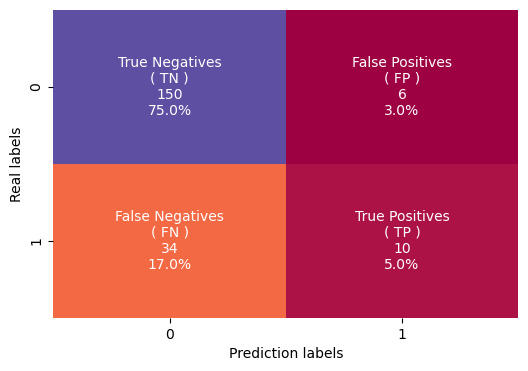

Log_RandOver:
mean Accuracy: 0.655 (0.0318)
mean Recall: 0.639 (0.1159)
mean F1_score: 0.448 (0.0642)



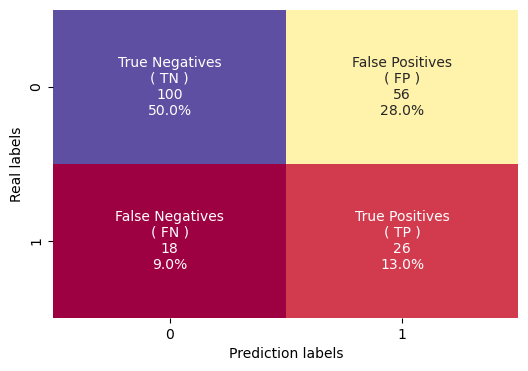

Log_TomekLinks:
mean Accuracy: 0.654 (0.0357)
mean Recall: 0.653 (0.0881)
mean F1_score: 0.455 (0.0529)



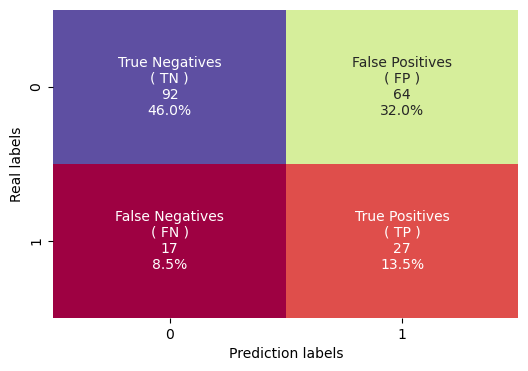

Log_SMOTE:
mean Accuracy: 0.663 (0.0349)
mean Recall: 0.528 (0.1025)
mean F1_score: 0.407 (0.0642)



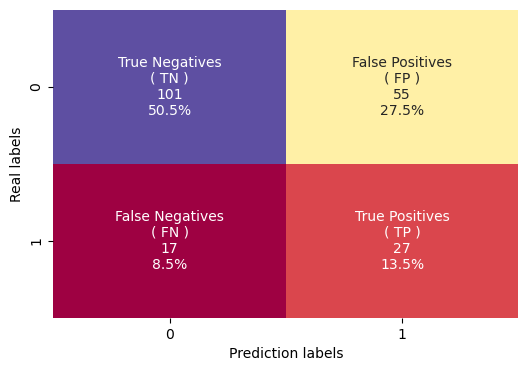

Log_SMOTEENN:
mean Accuracy: 0.611 (0.0377)
mean Recall: 0.725 (0.0456)
mean F1_score: 0.453 (0.0349)



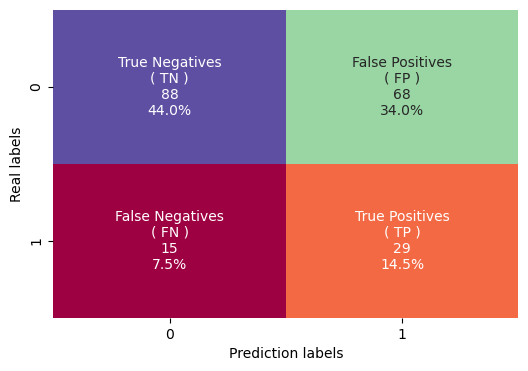

RandForest:
mean Accuracy: 0.774 (0.0163)
mean Recall: 0.113 (0.0511)
mean F1_score: 0.178 (0.0749)



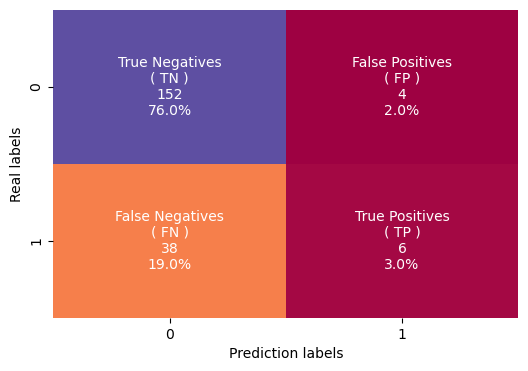

In [224]:
process=process_model()
process.list_models()
